# Mirko Michele D'Angelo - Assignment 3

First we load the data of the MNIST dataset, both training and test sets.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
#load training images
tr_images=idx2numpy.convert_from_file('./dataset/train-images.idx3-ubyte')
tr_labels=idx2numpy.convert_from_file('./dataset/train-labels.idx1-ubyte')
#load test images
ts_images=idx2numpy.convert_from_file('./dataset/t10k-images.idx3-ubyte')
ts_labels=idx2numpy.convert_from_file('./dataset/t10k-labels.idx1-ubyte')

# Implementation
First we implement our RBM along the CD-1 training algorithm using the methods implementation of the RBM class below:
- The __ __init__ __ constructor wll just initialize the values used for the biases and weights, in particulare the weights are initialized according to [this paper](http://www.cs.toronto.edu/%7Ehinton/absps/guideTR.pdf) with a gaussian distribution $N(0,0.01)$ the same goes for the hidden biases with a value of 0.
- __sample_hidden__ and __sample_visible__ implement for the corrisponding operation of sampling $h$ given $v$ and sampling $v$ given $h$.
- the __train__ method implements the actual training using the CD-1 algorithm with minibatch and MSE as a loss function to monitor the reconstruction error.
- the __encode__ method allows us to get the activations of hidden units and use them to encode data.
- the __reconstruct__ method allows us to reconstsruct the data it is passed as argurment.
- also a simple sigmoid implementation and a utility sampling method are used to implement the other methods in the class.

In [31]:
class RBM:
    def __init__(self,visible_size,hidden_size):
        self.visible_bias= np.zeros(visible_size,dtype='longdouble')
        self.hidden_bias= np.zeros(hidden_size,dtype='longdouble')

        self.weights=np.random.normal(scale=0.01,size=(visible_size,hidden_size))
        print(f"buildinig a RBM with {visible_size} visible units and {hidden_size} hidden units")
    def _sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def _sample(self,prob):
        return (prob > np.random.rand(*prob.shape)).astype(np.longdouble)
    def sample_hidden(self,v):
        ha_prob= self._sigmoid(v@self.weights+self.hidden_bias)
        ha_states= self._sample(ha_prob)
        return ha_prob,ha_states
    def sample_visible(self,h):
        recon_prob= self._sigmoid(h@self.weights.T+self.visible_bias)
        recon_act= self._sample(recon_prob)
        return recon_prob,recon_act

    def train(self,values,eta=0.01,epochs=100,batch_size=64):
        print(f"training over {values.shape[0]} samples with {values.shape[1]} features \nepochs={epochs}\t batch size={batch_size}\t learning rate={eta}")
        for e in range(epochs):
            for i in range(0,values.shape[0],batch_size):
                # clamp data as input
                clamped_data= values[i:i+batch_size]
                #sample h given v
                ha_prob,ha_states=self.sample_hidden(clamped_data)
                #calculate wake part
                wake=clamped_data.T@ha_prob
                #sample v given h
                recon_prob,recon_act=self.sample_visible(ha_states)
                active_prob=self._sigmoid(recon_act@self.weights+ self.hidden_bias)
                #calculate dream part
                dream=recon_act.T@active_prob
                delta_w=(wake-dream)/batch_size
                delta_bh = (np.mean(ha_prob-active_prob, axis=0))
                delta_bv = (np.mean(clamped_data-recon_act, axis=0))

                self.weights+=eta*delta_w
                self.hidden_bias+=eta*delta_bh
                self.visible_bias+=eta*delta_bv
            clamped_data= values
            """ ha_prob,ha_states=self.sample_hidden(clamped_data)
            recon_prob,recon_act=self.sample_visible(ha_states) """
            recon_act= self.reconstruct(clamped_data)
            print(f"epoch no.{e+1} reconstruction error: {np.mean((clamped_data-recon_act)**2)}")
    def reconstruct(self,data):
        _,ha_states=self.sample_hidden(data)
        recon_prob,recon_act=self.sample_visible(ha_states)
        return recon_act
    def encode(self,data):
        #sample h given v
        _,ha_states=self.sample_hidden(data)
        print(f"{ha_states.shape[0]} samples encoded with {ha_states.shape[1]} hidden units")
        return ha_states

## RBM training
Now we train the RBM, first the data from mnist dataset is flattened from a $(28 \times 28)$ matrix of integers between 0 and 255 to an array of 768 integers.
After the flattening binarization is applied with a threshold of 127 to get values that are either 0 or 1.

The reason for the flattening is just to be able to feed it into the rbm while the binarization is useful since it allows the contrastive divergence algorithm to properly work.

In [33]:
def flatten_and_binarize(images):
    threshold=np.random.rand(*images.shape)
    return (images>threshold).reshape((-1,28*28)).astype(np.int32)

In [34]:
rbm=RBM(28*28,50)

training=flatten_and_binarize(tr_images)

visible_active_prob=np.mean(training,axis=0)

rbm.visible_bias=np.log(visible_active_prob/(1-visible_active_prob))
maxv=max(rbm.visible_bias[np.isfinite(rbm.visible_bias)])
minv=min(rbm.visible_bias[np.isfinite(rbm.visible_bias)])
rbm.visible_bias=np.clip(rbm.visible_bias,minv,maxv)
rbm.train(training,
          eta=0.01,
          epochs=10,
          batch_size=10
          )

buildinig a RBM with 784 visible units and 50 hidden units


C:\Users\katyg\AppData\Local\Temp\ipykernel_14052\3893341065.py:7: RuntimeWarning: divide by zero encountered in log
  rbm.visible_bias=np.log(visible_active_prob/(1-visible_active_prob))


training over 60000 samples with 784 features 
epochs=10	 batch size=10	 learning rate=0.01
epoch no.1 reconstruction error: 0.10955958758503401
epoch no.2 reconstruction error: 0.09596488095238095
epoch no.3 reconstruction error: 0.09018675595238096
epoch no.4 reconstruction error: 0.08686505102040816
epoch no.5 reconstruction error: 0.08476315901360544
epoch no.6 reconstruction error: 0.08320625
epoch no.7 reconstruction error: 0.08188552295918368
epoch no.8 reconstruction error: 0.0809280612244898
epoch no.9 reconstruction error: 0.08029713010204081
epoch no.10 reconstruction error: 0.07974330357142857


The same treatment also goes for the test set.

In [35]:
test=flatten_and_binarize(ts_images)


## getting binary activations
Using the encode method i can encode both training and test set of images using the hidden states activations.

First we encode both training and test images using our RBM.

In [36]:
h_train=rbm.encode(training)
h_test=rbm.encode(test)

60000 samples encoded with 50 hidden units
10000 samples encoded with 50 hidden units


## results


## classifers confrontation

Now we can confront the difference between using the normal MNIST dataset and its correspondent activation.

To make this confrontation i decided to use the f-score,acuracy and recall metric with a heatmap to checck the model generalization capabilities on the test set.

The model i decided to use is a linear SVM, the reason for the SVM is to see the difference between training on high dimensional data and then using the hidden activations.

C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

results of training on raw data 
 precision=30.16% recall=14.07% f-score=8.32%


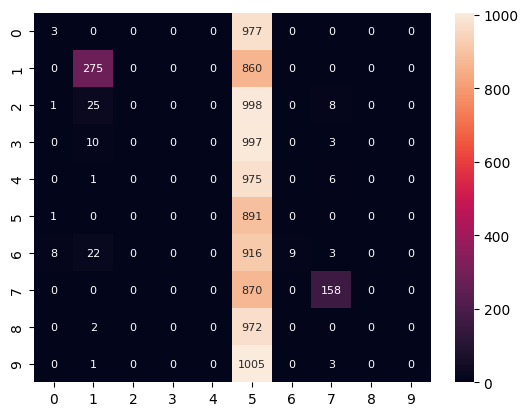

In [38]:
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support
import seaborn as sns
#raw training with the original values
mlp=LinearSVC().fit(tr_images.reshape((-1,28*28)),tr_labels) 
pred=mlp.predict(test)
sns.heatmap(confusion_matrix(ts_labels,pred),annot=True,annot_kws={"size": 8},fmt='d')
precision,recall,fscore,_=precision_recall_fscore_support(ts_labels,pred,average='macro')
print(f"results of training on raw data \n precision={100*precision:.2f}% recall={100*recall:.2f}% f-score={100*fscore:.2f}%")


Now we can use our encoded dataset to train the model and see if generalization capabilities have enhanced.

C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


results of training on hidden activations encoding 
 precision=87.92% recall=87.75% f-score=87.74%


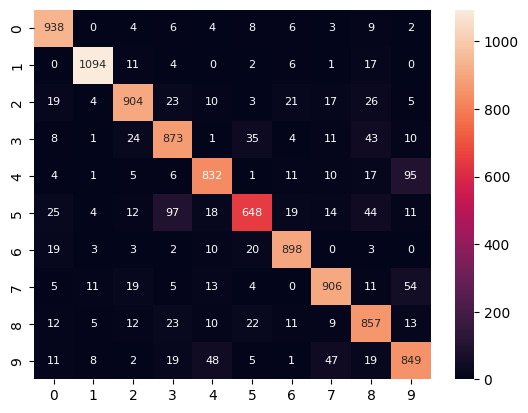

In [39]:
# training on encoded values
mlp=LinearSVC().fit(h_train,tr_labels)
pred=mlp.predict(h_test)
sns.heatmap(confusion_matrix(ts_labels,pred),annot=True,annot_kws={"size": 8},fmt='d')
precision,recall,fscore,_=precision_recall_fscore_support(ts_labels,pred,average='macro')
print(f"results of training on hidden activations encoding \n precision={100*precision:.2f}% recall={100*recall:.2f}% f-score={100*fscore:.2f}%")

As we can see the improvement is great and gives us a very high f-score of 90%.

Now we evaluate if more flexible models will get any sort of enhacement by using the hidden activations instead of the normal MNIST dataset. For this second attempt i decided to use a LogisticRegression that is more flexible and adapts easier to data so it should have better results even on the original data. 

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
#raw training with values
mlp=LogisticRegression().fit(tr_images.reshape((-1,28*28)),tr_labels)
pred=mlp.predict(test)
print(f"raw {f1_score(ts_labels,pred,average='macro')}")
mlp=LogisticRegression().fit(training,tr_labels)
pred=mlp.predict(test)
print(f"binarized {f1_score(ts_labels,pred,average='macro')}")
# training on encoded values
mlp=LogisticRegression().fit(h_train,tr_labels)
h_pred=mlp.predict(h_test)
print(f"encoded {f1_score(ts_labels,h_pred,average='macro')}")

C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


raw 0.9051689447694169


C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


binarized 0.9168652718172394
encoded 0.888063055032539


C:\Users\katyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0).fit(tr_images.reshape((-1,28*28)),tr_labels)
pred=clf.predict(ts_images.reshape((-1,28*28)))
print(f1_score(ts_labels,pred,average="micro"))
clf = RandomForestClassifier(max_depth=2, random_state=0).fit(training,tr_labels)
pred=clf.predict(test)
print(f1_score(ts_labels,pred,average="micro"))
clf = RandomForestClassifier(max_depth=2, random_state=0).fit(h_train,tr_labels)
pred=clf.predict(h_test)
f1_score(ts_labels,pred,average="micro")


0.6364
0.646


0.7086

In this case case we still have a gain on the f-score, but only by 2%.

## final considerations

RBMs are good model that has the capability of learning representations from data, it offers a nice dimensionality reduction that lets use simpler models to achieve good results.
However they can be costly to train when we have a lot of data and we use a lot of hidden activations the trainig time increases significantly and might make too costly,also it is not easy to interpret the learned representations.
